In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # pour afficher la map de corrélation
import scipy as sc # H0 = non-correlation (assumption that each dataset is normally distributed)

dataframe = pd.read_csv("./data/conso/conso_2018.csv")
dataframe.columns

Index(['mois', 'jour', 'heure', 'consommation', 'prevision_1', 'prevision_0',
       'fioul', 'charbon', 'gaz', 'nucleaire', 'eolien', 'solaire',
       'hydraulique', 'pompage', 'bioenergies', 'echanges_physiques',
       'taux_co2', 'echanges_angleterre', 'echanges_espagne',
       'echanges_italie', 'echanges_suisse', 'echanges_allemagne_belgique',
       'fioul_tac', 'fioul_cogen', 'fioul_autres', 'gaz_tac', 'gaz_cogen',
       'gaz_ccg', 'gaz_autres', 'hydro_ecluses', 'hydro_lacs',
       'hydro_turbines', 'bio_dechets', 'bio_biomasse', 'bio_biogaz'],
      dtype='object')

# from split import retrieve

In [14]:
def retrieve(year):
    """Retrieve data"""
    path_X =  "./data/conso/conso_" + str(year) + ".csv"
    path_Y =  "./data/pertes/pertes_" + str(year) + ".csv"
    X = pd.read_csv(path_X).to_numpy()
    Y = pd.read_csv(path_Y).to_numpy()[:, 3]
    
    return X, Y

# Code

In [85]:
X, Y = retrieve(2018)
print(X.shape)
print(Y.shape)

X = (X - X.mean(0)) / (X.std(0)+1e-11)

(8760, 35)
(8760,)


### Test de corrélation (Pearson)

Text(0.5, 1, 'Absolute Pearson correlation between features')

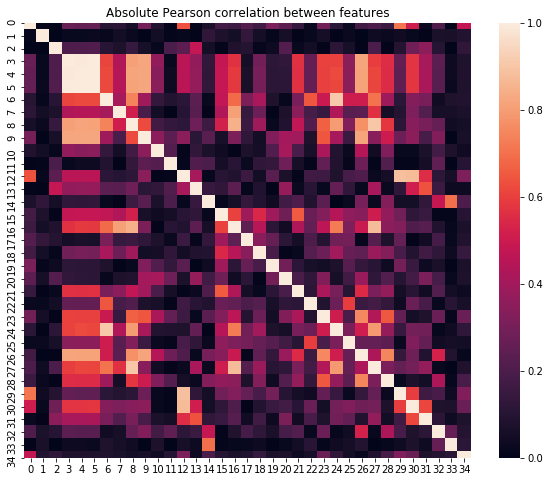

In [169]:
n, p = X.shape

inner_corr = np.zeros((p, p))
target_corr = np.zeros(p)
for i in range(p):
    target_corr[i] = sc.stats.pearsonr(X[:, i], Y)[0]
    for j in range(p):
        inner_corr[i, j] = sc.stats.pearsonr(X[:, i], X[:, j])[0]

# afficher la map de corrélation entre features

plt.figure(figsize=(10,8))
sns.heatmap(abs(inner_corr), annot=False)
plt.title("Absolute Pearson correlation between features")

Les features 3, 4 et 5 c'est des doublons : elles sont ultra corrélées entre elles et elles n'apportent aucune infos en plus (les 3 ont les mêmes corrélations avec les autres). 

In [189]:
# trouver les variables répétitives (celles de grande corrélation) et supprimer les doublons

seuil = 0.85 # 0.5 c'est déjà restrictif
high_corr = inner_corr > seuil
for i in range(p):
    high_corr[i, i] = False

possede_doublons = []
for i in range(p):
    if np.sum(high_corr[i]) > 0 :
        possede_doublons.append(i)

# à la main
        
groupes_doublons = []
for i in possede_doublons :
    group = [i]
    for j in range(p) :
        if high_corr[i, j] :
            group.append(j)
    not_sorted_group = group[:]
    group.sort()
    if group not in groupes_doublons:
        groupes_doublons.append(not_sorted_group)

doublons = (4, 5, 12, 24, 16, 27)
no_doublon = np.delete(np.arange(p), doublons)

# automatisé

corr = np.copy(inner_corr)
doublons = []
removed = np.zeros(p)
for i in possede_doublons :
    for j in possede_doublons :
        if high_corr[i, j] :
            index = max(i, j)
            if removed[index] :
                continue
            else :
                doublons.append(index)
                np.delete(corr, index, axis=0)
                np.delete(corr, index, axis=1)
                removed[index] = 1
doublons = tuple(doublons)
no_doublon = np.delete(np.arange(p), doublons)

print("doublons à supprimer pour un seuil de", seuil, ":", doublons)

doublons à supprimer pour un seuil de 0.85 : (4, 5, 24, 16, 27, 29, 30)


Donc (les groupes de corréation sont très claires) :
- 3, 4, 5 sont des doublons (très corrélés et toujours présents dans les mêmes groupes)
- 12, 29, 30 sont des doublons (2 à 2)
- 6, 24 sont des doublons
- 8, 16, 27 sont des doublons

On décide de supprimer : 4, 5, 12, 24, 16, 27.

### Variable selection with Pearson

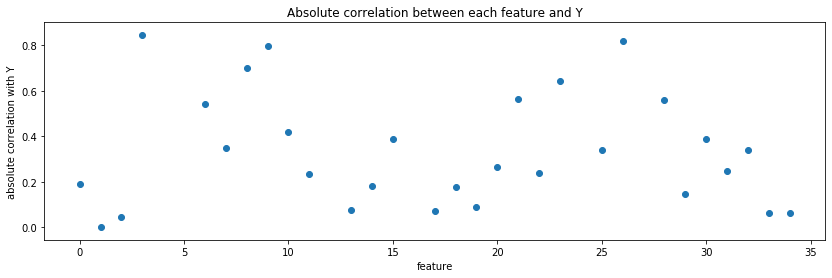

In [150]:
# afficher la map de corrélation entre chaque feature et Y

plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(abs(target_corr), doublons))
plt.xlabel("feature")
plt.ylabel("absolute correlation with Y")
plt.title("Absolute correlation between each feature and Y")
plt.show()

In [132]:
# remove the very little correlated feature to Y

seuil = 0.05
low_corr = []
for i in range(p):
    if target_corr[i] < seuil :
        low_corr.append(i)
print(low_corr)

[0, 1, 2, 11, 19, 20, 33, 34]


### Variable selection with PCA

In [139]:
K = np.transpose(X).dot(X)/n
pca_eig_values, pca_eig_vectors = np.linalg.eigh(K)[:2] # the eigen vectors are ordered by ascendant eigen value

def pca(X, l): # l = number of principal components
    E = pca_eig_vectors[:, -l:]
    norm_proj = np.linalg.norm(E, axis=1)
    principal_corr = np.zeros((l, p))
    for i in range(l):
        for j in range(p):
            principal_corr[i, j] = np.sqrt(pca_eig_values[-i-1]) * abs(E[j, -i-1] / K[j, j])
    return norm_proj, np.sum(principal_corr, axis=0)

proj_20, corr_20 = pca(X, 20)
proj_15, corr_15 = pca(X, 15)
proj_10, corr_10 = pca(X, 10)

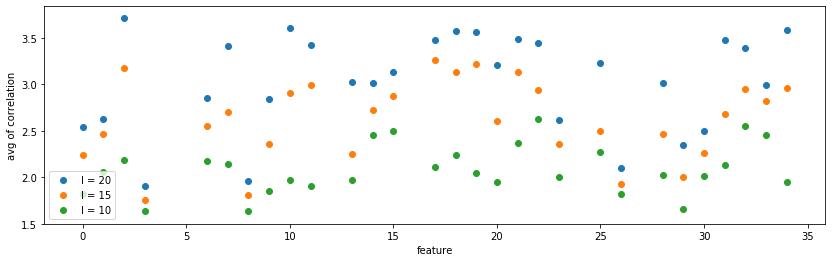

In [151]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(corr_20, doublons), label="l = 20")
plt.scatter(no_doublon, np.delete(corr_15, doublons), label="l = 15")
plt.scatter(no_doublon, np.delete(corr_10, doublons), label="l = 10")
plt.xlabel("feature")
plt.ylabel("avg of correlation")
plt.legend(loc=3)
plt.show()

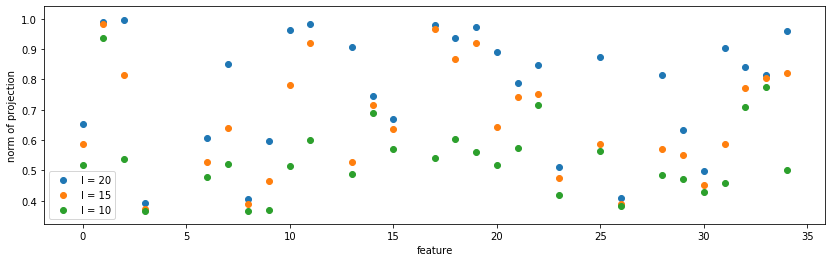

In [152]:
plt.figure(figsize=(14,4))
plt.scatter(no_doublon, np.delete(proj_20, doublons), label="l = 20")
plt.scatter(no_doublon, np.delete(proj_15, doublons), label="l = 15")
plt.scatter(no_doublon, np.delete(proj_10, doublons), label="l = 10")
plt.xlabel("feature")
plt.ylabel("norm of projection")
plt.legend(loc=3)
plt.show()